## DQN Cartpole-vo 예시

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

## CartPole-v0 환경을 이용, 폴이 안쓰러지게 학습
env = gym.make('CartPole-v0').unwrapped

plt.ion()



## GPU를 사용할 경우
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Element
* 에이전트(Agent) : Cart
* 환경(Enviornment) : Cart Position,Velocity / Pole Angle , Velocity
* 상태(State) : Cart & Pole Status // 현재 코드에서는 Screen을 통해서 얻음
* 행동(Action)  : Push Cart to the Left or Right
* 정책(Policy) : 네트워크 + Select Action 
    (Input : State / Output : Action Values => Select Action using Action values)
* 보상(Reward) : 각 Step 마다 1점
* 에피소드(Episode) : 폴이 넘어지면 Episode가 끝남 
* 감가율(Discount Factor) : Gamma / 
* 행동 가치(State-Action-Value) : 네트워크를 통해 나온 계산 값
* Exploration method : Epsilon- Greedy / epsilon 값이 크면 Exploration 할 확률이 크다
* Off - policy : Using Replay Buffer / Policy_net & Target_net

# Algorithm
* DQN Algorithm : Bellman equation을 통해 Q(s,a) = reward + discout reward * Q(s',a')인데, 여기서 Error를 찾을 수 있다. 
    TD-error : Q(s,a) - reward + discout reward * Q(s',a') 이고 이때 Huber Loss 를 이용한다. 

* loss 정의 이유 : 네트워크가 하는 일은 State-Action-value를 추정하는 것이다.
    *  네트워크를 통해  Q(s,a) 값과 Q(s',a') 값을 추정하고 V(s') = maxQ(s',a')을 얻어 Q(s,a) = V(s') * gamma(discount factor) + reward 이어야 함으로 Q(s,a)와 V(s')*gamma +reward 값을 loss로 정의한다.
   
    

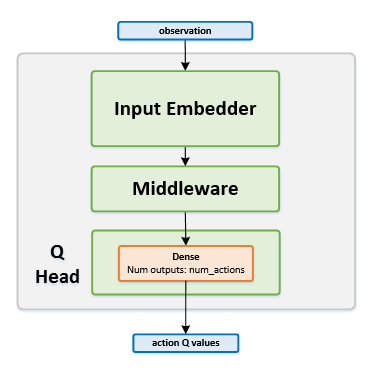
reference : https://nervanasystems.github.io/coach/components/agents/value_optimization/dqn.html

In [2]:
## Experience Replay
## 학습에 이용할 메모리
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        """transition 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        self.position = (self.position + 1) % self.capacity
        if len(self.memory) >= self.capacity: 
            self.memory[self.position] = transition

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Neural Network를 사용한다

In [3]:
## 큰 차원의 데이터를 다루기위해서 사용


## 학습에 쓰이는  NN 
## Input은 State가 되고 Output은 Q - value가 된다.
class DQN(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2,action_size)

    ## 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됨.
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
      

In [4]:
## HYPERPARAMETERS

BATCH_SIZE = 30
GAMMA = 0.9
EPS_START = 0.99
EPS_END = 0.05
EPS_DECAY = 300
num_episodes = 200
input_size = env.observation_space.shape[0]
hidden_size = 50


## 메모리 크기
memory = ReplayMemory(100000)

## gym 행동 공간에서 행동의 숫자를 얻기.
n_actions = env.action_space.n

## 네트워크를 초기화한다. 
policy_net = DQN(input_size,hidden_size, n_actions)
target_net = DQN(input_size,hidden_size, n_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

## 최적화 기준 RMS(Root Mean Squeare)
optimizer = optim.RMSprop(policy_net.parameters(), lr =0.001)


In [5]:
## 몇번의 스탭을 했는지.
steps_done = 0

## e- greedy를 이용한 Action 선택
def select_action(state):
    global steps_done
    ## 0과1사이의 값을 무작위로 가져옴
    sample = random.random()
    ## Epsilon-Threshold의 값이 step이 반복될 수록 작아진다.
    ## 점점 greedy action을 택하게 만듬.
    steps_done += 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * (steps_done) / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            """
            t.max (1)은 각 행의 가장 큰 열 값을 반환합니다.
            최대 결과의 두번째 열은 최대 요소의 주소값이므로,
            기대 보상이 더 큰 행동을 선택할 수 있습니다.
            """
            action = policy_net(Variable(state))

            return torch.FloatTensor(action).data.max(1)[1].view(1,1)
        # Random action 선택
    else:
        return torch.LongTensor([[random.randrange(n_actions)]])



In [6]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    plt.axhline(y=200,linestyle = '--')
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    '''
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    '''

## 최적화 모델
DQN의 최적화 모델은 앞으로 Double,Dueling에서도 유사하게 나온다.

#Pseudo Code
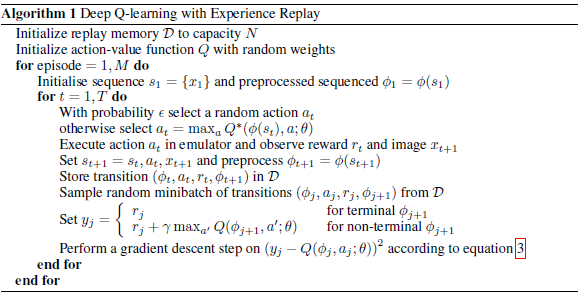

reference : https://sumniya.tistory.com/18

In [7]:
## Optimize
def optimize_model_DQN():
    if len(memory) < BATCH_SIZE:
        return
    ## Memory에서 Sample을 가져옴    
    transitions = memory.sample(BATCH_SIZE)
    
    ## Batch로 나눔.
    state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
    
    ## Sample에서 나온 값들을 각각 모음.
    state_batch = torch.cat(state_batch)
    next_state_batch = Variable(torch.cat(next_state_batch))
    action_batch = Variable(torch.cat(action_batch))
    reward_batch = Variable(torch.cat(reward_batch))
    done_batch = Variable(torch.cat(done_batch))
    
    
    ## Pseudo Code 12,13 번째 줄 참고!
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_action_values =policy_net(next_state_batch).max(1)[0]
    
    ## 기대 Q 값 계산
    expected_state_action_values = reward_batch + (GAMMA * next_state_action_values)*(1-done_batch)
    

    ## Huber 손실 계산 / L1 loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    ## 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    ## Gradient의 변화가 너무 크지 않게 만듬.
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


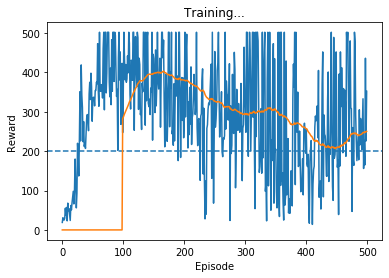

Complete


In [14]:
## 폴이 쓰러지면 한번에 에피소드가 종료
## 이 부분을 여러번 돌리면 학습을 여러번 한 효과

for i_episode in range(num_episodes):
    ## 환경과 상태 초기화
    state = env.reset()
    ## 에피소드 시작 / 폴이 넘어지면 에피소드가 끝남
    for t in count():

        ## 행동 선택과 수행
        state = torch.FloatTensor([state])
        
        action = select_action(state)
        
        next_state, reward, done, _ = env.step(action.item())
        
        
        if done : 
            reward = -100
        
        ## 메모리 저장(한번에 에피소드에 많은 메모리가 생김)
        memory.push((state,action, torch.FloatTensor([next_state]), \
                    torch.FloatTensor([reward]),torch.FloatTensor([done])))

        
        if done or t > 500:
            episode_durations.append(t+1)
            break        
        
        ## 다음 상태로 이동
        state = next_state
        
        ## 최적화 한단계 수행(Policy 네트워크에서)
        optimize_model_DQN()
    
    ## Output을 계속 볼수 있게
    if i_episode % 100 == 0:
        plot_durations()
    if i_episode % 1000 == 0 :
        clear_output()
    

plot_durations()
print('Complete')
## Target Network의 복사. 테스트용
target_net.load_state_dict(policy_net.state_dict())
plt.ioff()
plt.show()

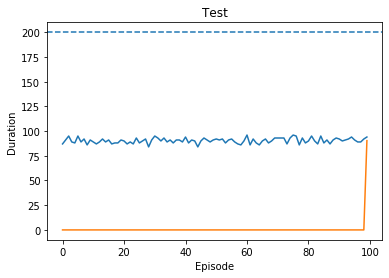

Complete


In [15]:
## Testing Section
results = []
num_episodes =100
i_episode = 0
for i_episode in range(num_episodes):
    # 환경과 상태 초기화
    state = env.reset()

    for t in count():
        # 행동 선택과 수행 / Test하는 과정이므로 학습된 네트워크가 행동 결정
        state = torch.FloatTensor([state])
        
        action = target_net(Variable(state))

        action = torch.FloatTensor(action).data.max(1)[1].view(1,1)
        
        next_state, reward, done, _ = env.step(action.item())
               
      
        if done or t > 500:
            results.append(t + 1)
            break 
        
        
        # 다음 상태로 이동
        state = next_state

    

def plot_durations1():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(results, dtype=torch.float)
    plt.title('Test')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.axhline(y=200,linestyle ='--')
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    
    
    
    
plot_durations1()
print('Complete')

#writer.close()

plt.ioff()
plt.show()

Comments : 결과 나오면